# Import Libraries and Load Data

In [1]:
# suppress future warnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# Data visualisations
import matplotlib.pyplot as plt

# Base libraries
import numpy as np
import pandas as pd

# More data viz
import plotly.express as px
import seaborn as sns

# to use pandas dtypes in matplotlib plots
from pandas.plotting import register_matplotlib_converters

# rich
from rich.console import Console

# define rich console for formatted output
console = Console()

# have pandas types plotted with matplotlib
register_matplotlib_converters()

# set plotly as backend for plots wih pandas
pd.options.plotting.backend = "plotly"

# create a dict to update plotly layout
plotly_styles = dict(
    font_family="DejaVuSansMono Nerd Font",
    template="none",
    title={
        "x": 0.05,
        # basically, what part of the title to put at position "x"
        "xanchor": "left",
    },
)


# set settings for seaborn
sns.set_style(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")  # will be useful later

# visualise plots inline
%matplotlib inline

# customise matplotlib and sns plot dimensions
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100

We use `squeeze=True` to indicate that our data has only one column and we want to retrieve a `pandas.Series` (see [here](https://machinelearningmastery.com/load-explore-time-series-data-python/))

In [2]:
daily_rentals = pd.read_csv(
    "../data/bikemi_csv/daily_outflow.csv", index_col=[0], parse_dates=[0], squeeze=True
).asfreq(
    freq="D"
)  # set frequency

print(f"Our data is a {type(daily_rentals)}")

daily_rentals

Our data is a <class 'pandas.core.series.Series'>


giorno_partenza
2019-01-01     831
2019-01-02    3512
2019-01-03    4126
2019-01-04    4201
2019-01-05    2875
              ... 
2019-12-27    2995
2019-12-28    1944
2019-12-29    1269
2019-12-30    2698
2019-12-31    2126
Freq: D, Name: count, Length: 365, dtype: int64

We also need to make sure our index has a frequency - which we did with `.asfreq("D")` above:

In [3]:
daily_rentals.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='giorno_partenza', length=365, freq='D')

# Naïve forecaster

We need to fit a naïve forecaster to have a benchmark for our other methods:

In [4]:
# to define forecasting horizon
from sktime.forecasting.base import ForecastingHorizon

# to perform train-test split
from sktime.forecasting.model_selection import temporal_train_test_split

# to establish the naive forecaster benchmark
from sktime.forecasting.naive import NaiveForecaster

We also need to choose the forecasting metrics. Since we will be forecasting several models on the same data, we can use both scale-dependent errors (mean absolute error, root mean squared error) and percentage errors (mean absolute percentage error). We can also employ a scaled error, such as the mean absolute scaled error (MASE, proposed by <cite id="11q8p">[NO_PRINTED_FORM]</cite>).

`mean_absolute_error`, `mean_squared_error`, `mean_absolute_percentage_error` and `mean_absolute_scaled_error` also have an argument for adding weights to the forecast.

In [71]:
from sktime.performance_metrics.forecasting import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_absolute_scaled_error,
    mean_squared_error,
)


def model_diagnostics(
    y_pred: pd.Series,
    y_true: pd.Series = y_test,
    y_train: pd.Series = y_train,
    mase: bool = True,
) -> pd.DataFrame:

    metrics = ["MAE", "RMSE", "MAPE"]

    scores = [
        mean_absolute_error(y_true, y_pred),
        mean_squared_error(y_true, y_pred, square_root=True),
        mean_absolute_percentage_error(y_true, y_pred, symmetric=False),
    ]

    if mase:
        metrics.append("MASE")
        scores.append(mean_absolute_scaled_error(y_true, y_pred, y_train=y_train))

    return pd.DataFrame({"metrics": metrics, "scores": scores})

We will be using a Seasonal Naive Forecaster (link Hyndman) where the predicted value is the one of the last seasonal value (i.e., 7 days before):

In [64]:
# perform train-test splitting
y_train, y_test = temporal_train_test_split(daily_rentals, test_size=0.1)

# uses all of the test set as forecasting horizon
fh = ForecastingHorizon(y_test.index, is_relative=False)

# naive forecaster model definition
naive_forecaster = NaiveForecaster(
    strategy="last",
    # weekly seasonal periodicity
    sp=7,
)

# naive forecaster model fitting
naive_forecaster.fit(y_train)

# naive forecaster predictions
naive_pred = naive_forecaster.predict(fh)

# naive forecaster error
naive_diagnostics = model_diagnostics(naive_pred, mase=False)

naive_diagnostics

,metrics,scores
0,MAE,2773.189189
1,RMSE,3646.760302
2,MAPE,0.812073


Our model has 64% MAPE - whereas one might have expected something more. Let's plot it to see the differences:

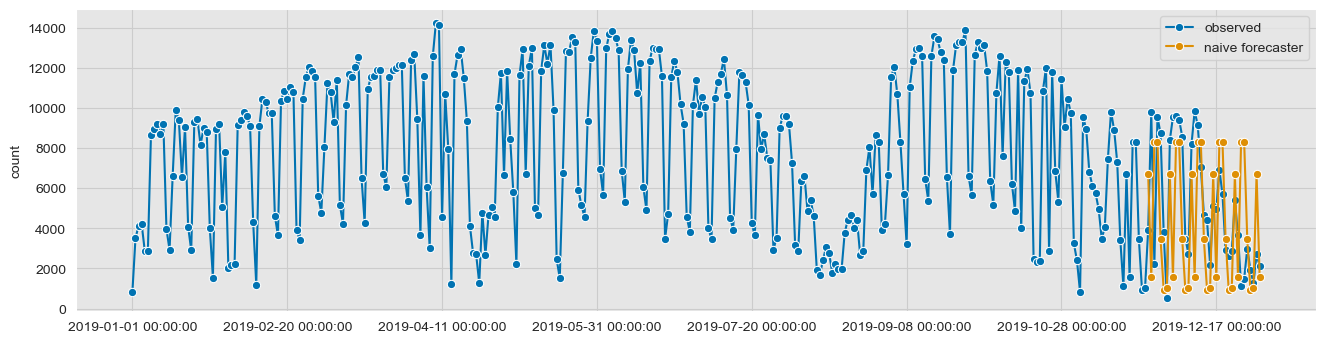

In [65]:
from sktime.utils.plotting import plot_series

plot_series(daily_rentals, naive_pred, labels=["observed", "naive forecaster"])

plt.show()

# ARIMA Model

The autocorrelation plot suggested us to use:

* an autoregressive component $p$ of 1
* an integration $d$ of order 1
* a moving average component $q$ of 1
* an autorgressive seasonal component $P$ of 2 with periodicity $m$ of 7
* an seasonal integration $D$ of order 1
* a moving average seasonal component $P$ of 3 with periodicity $M$ of 7

An interesting feature of the ARIMA class is that it provides arguments to perform cross validation directly within the model specification step:

```md
`out_of_sample_size` int, optional (default=0)
The number of examples from the tail of the time series to hold out and use as validation examples. The model will not be fit on these samples, but the observations will be added into the model’s endog and exog arrays so that future forecast values originate from the end of the endogenous vector. See update. For instance:

y = [0, 1, 2, 3, 4, 5, 6]
out_of_sample_size = 2
> Fit on: [0, 1, 2, 3, 4]
> Score on: [5, 6]
> Append [5, 6] to end of self.arima_res_.data.endog values

`scoring` str or callable, optional (default=’mse’)
If performing validation (i.e., if out_of_sample_size > 0), the metric to use for scoring the out-of-sample data:

* If a string, must be a valid metric name importable from sklearn.metrics.
* If a callable, must adhere to the function signature [...]
```

By default, the ARIMA model is fit with a trend and a constant.

/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


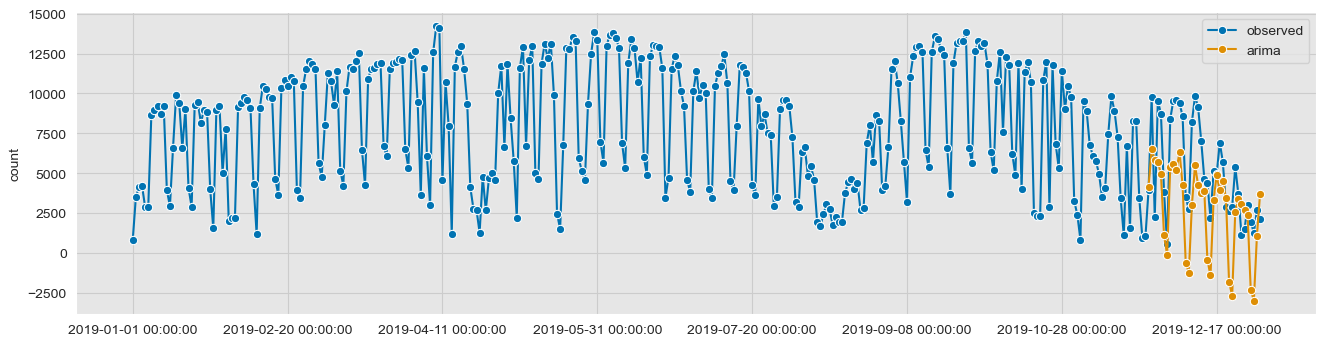

In [66]:
from sktime.forecasting.arima import ARIMA

# model specification
arima = ARIMA(order=(3, 1, 3), seasonal_order=(3, 1, 3, 7), maxiter=500)

# model fitting
arima_fit = arima.fit(y_train)

# predictions
arima_pred = arima_fit.predict(fh)

# plot the model
plot_series(daily_rentals, arima_pred, labels=["observed", "arima"])

plt.show()

In [72]:
# arima model error
arima_diagnostics = model_diagnostics(arima_pred)
arima_diagnostics

,metrics,scores
0,MAE,2888.394591
1,RMSE,3294.701301
2,MAPE,0.793700
3,MASE,1.104922


The performance is just marginally better, compared to our naive forecaster. This can be due to multiple reason, the first one being the increase in volatility of the series in the winter months. This might hint that using external regressors might improve on the model, but as of this stage we cannot be sure. Ideally, we might want to find a way to tell the model to fit a steeper trend.

Scoring can also be computed directly using the following:

```python
arima.score(y_test)
```

By default, the algorithm will allow for a maximum of 50 iterations. This can mean that the estimator might not converge. We set `maxiter` to 500 as a precautionary measure.

Let's see the model summary:

In [34]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  328
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 7)   Log Likelihood               -2904.235
Date:                           Mon, 30 Aug 2021   AIC                           5836.470
Time:                                   22:09:11   BIC                           5889.226
Sample:                                        0   HQIC                          5857.536
                                           - 328                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -35.1834     26.524     -1.326      0.185     -87.170      16.803
ar.L1         -1.4987      0.069    -21.597      0.000      -1.635      -1.363
ar.L2         -0.5599      0.121     -4.643      0.000      -0.796      -0.324
ar.L3          0.2080      0.068      3.070      0.002       0.075       0.341
ma.L1          0.9977      1.525      0.654      0.513      -1.991       3.986
ma.L2         -0.4257      0.503     -0.846      0.398      -1.412       0.561
ma.L3         -0.7952      1.343     -0.592      0.554      -3.427       1.837
ar.S.L7       -1.5465      0.112    -13.864      0.000      -1.765      -1.328
ar.S.L14      -0.6207      0.145     -4.276      0.000      -0.905      -0.336
ar.S.L21       0.1871      0.073      2.561      0.010       0.044       0.330
ma.S.L7        0.6984      1.706      0.409      0.682      -2.645       4.042
ma.S.L14      -0.7996      2.887     -0.277      0.782      -6.458       4.859
ma.S.L21      -0.8946      1.513     -0.591      0.554      -3.861       2.072
sigma2      4.035e+06   6.67e-07   6.05e+12      0.000    4.04e+06    4.04e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                94.75
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -0.78
Prob(H) (two-sided):                  0.16   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.46e+31. Standard errors may be unstable.
"""

The seasonal MA components are insignificant, as we might have expected from looking at the ACF plot. Each $AR$ component is actually meaningful: we might try to fit more of them.

The Ljung-Box is a portmanteau test for autocorrelation of the residuals. Our model pass the tests, i.e. the errors are serially non-correlated.

In [ ]:
ar = ARIMA()

# SARIMAX

Since the fit is so poor, we might want to include some external (exogenous) predictors. This can simply be done via the `fit` interface. We can reuse the code from our previous chapter - we just need to drop columns containing a string and turn `holiday` into a binary categorical variable:

In [22]:
# to add holidays features
import holidays

exogenous = (
    pd.DataFrame(daily_rentals)
    .reset_index()
    .assign(
        # we cannot use this yet, as there is only one year of observations available
        # year=lambda x: x["giorno_partenza"].dt.year,
        month=lambda x: x["giorno_partenza"].dt.month,
        week=lambda x: x["giorno_partenza"].dt.isocalendar().week,
        day=lambda x: x["giorno_partenza"].dt.weekday,
        is_weekend=lambda x: x["day"].apply(lambda day: 1 if day in [5, 6] else 0),
        day_of_month=lambda x: x["giorno_partenza"].dt.day,
        day_of_year=lambda x: x["giorno_partenza"].dt.dayofyear,
        holiday=lambda ts: ts["giorno_partenza"].apply(
            lambda x: holidays.CountryHoliday("IT").get(x)
        ),
        is_holiday=lambda ts: ts["holiday"].apply(lambda x: 1 if x is not None else 0),
    )
    .set_index("giorno_partenza")
    .astype({"week": "int64"})
    .drop(columns=["count", "holiday"], axis=1)
    .asfreq(freq="D")
)

exogenous.head()

,month,week,day,is_weekend,day_of_month,day_of_year,is_holiday
giorno_partenza,,,,,,,
2019-01-01,1,1,1,0,1,1,1
2019-01-02,1,1,2,0,2,2,0
2019-01-03,1,1,3,0,3,3,0
2019-01-04,1,1,4,0,4,4,0
2019-01-05,1,1,5,1,5,5,0


In [23]:
exogenous.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Freq: D
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   month         365 non-null    int64
 1   week          365 non-null    int64
 2   day           365 non-null    int64
 3   is_weekend    365 non-null    int64
 4   day_of_month  365 non-null    int64
 5   day_of_year   365 non-null    int64
 6   is_holiday    365 non-null    int64
dtypes: int64(7)
memory usage: 22.8 KB


We need to perform the temporal time split on this exogenous matrix too:

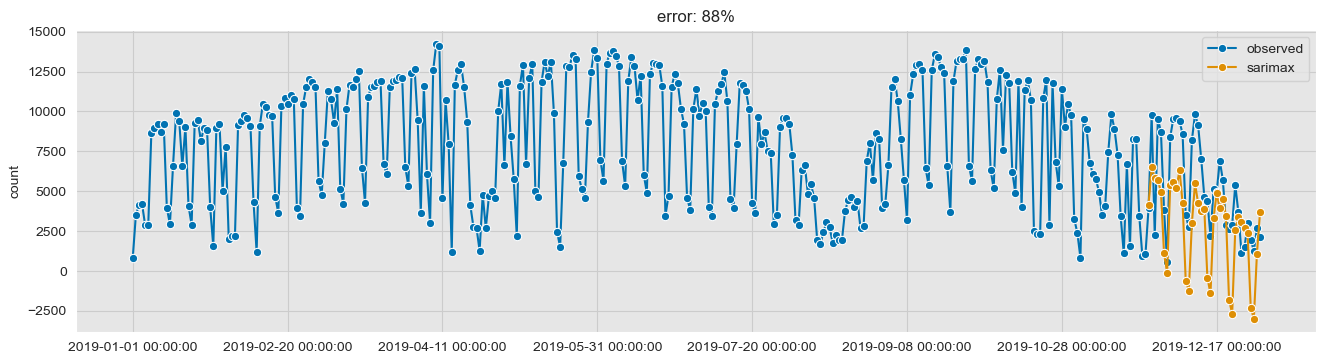

In [73]:
X_train, X_test = temporal_train_test_split(exogenous, test_size=0.1)

# model specification
sarimax = ARIMA(order=(1, 1, 1), seasonal_order=(2, 1, 3, 7), maxiter=500)

# model fitting
sarimax.fit(y_train, X=X_train)

# predictions
sarimax_pred = arima.predict(fh, X_test)

# arima model error
sarimax_error = mean_absolute_percentage_error(y_test, sarimax_pred)

# plot the model
plot_series(daily_rentals, sarimax_pred, labels=["observed", "sarimax"])

plt.title(f"error: {round(sarimax_error * 100)}%")

plt.show()

The performance of this model is underwhelming, to say the least. If we look at the model summary, we can immediately see why:

In [26]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                  273
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2, 3], 7)   Log Likelihood               -2377.400
Date:                                   Mon, 30 Aug 2021   AIC                           4786.800
Time:                                           21:37:05   BIC                           4844.076
Sample:                                       01-01-2019   HQIC                          4809.813
                                            - 09-30-2019                                         
Covariance Type:                                     opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -3.2142      4.954     -0.649      0.516     -12.924       6.495
month        -6389.9944    2.5e+04     -0.255      0.799   -5.55e+04    4.27e+04
week             4.3284   2.65e+04      0.000      1.000   -5.19e+04    5.19e+04
day            -24.1074   3730.143     -0.006      0.995   -7335.054    7286.839
is_weekend      -7.7208   4095.523     -0.002      0.998   -8034.799    8019.357
day_of_month  -201.5727    816.585     -0.247      0.805   -1802.049    1398.904
day_of_year    -37.7700   3028.396     -0.012      0.990   -5973.316    5897.776
is_holiday   -1426.2664    485.071     -2.940      0.003   -2376.989    -475.544
ar.L1            0.4466      0.090      4.941      0.000       0.269       0.624
ma.L1           -0.8210      0.065    -12.680      0.000      -0.948      -0.694
ar.S.L7         -0.6952      0.374     -1.859      0.063      -1.428       0.038
ar.S.L14         0.2104      0.317      0.664      0.507      -0.410       0.831
ma.S.L7          0.0242      2.023      0.012      0.990      -3.941       3.989
ma.S.L14        -0.9967      0.090    -11.060      0.000      -1.173      -0.820
ma.S.L21        -0.0209      0.361     -0.058      0.954      -0.729       0.687
sigma2        3.265e+06      0.165   1.98e+07      0.000    3.27e+06    3.27e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                54.10
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.66
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+27. Standard errors may be unstable.
"""

Every time component is statistically insignificant

# Auto ARIMA

The conclusion is pretty dire. Let's see if the AutoARIMA can improve on it:

/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: No

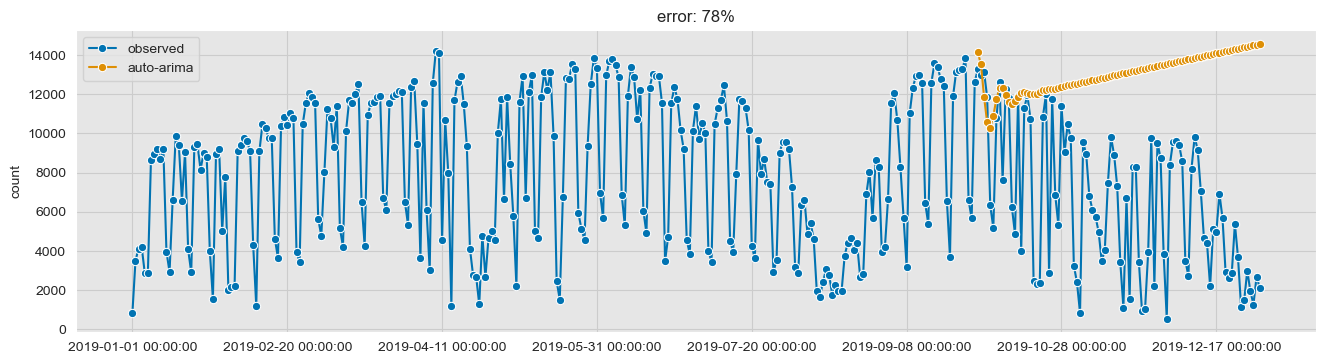

In [31]:
from sktime.forecasting.arima import AutoARIMA

auto_arima = AutoARIMA(d=1, max_order=10, maxiter=500)  # differencing order

auto_arima.fit(y_train)

auto_arima_pred = auto_arima.predict(fh)

auto_arima_error = mean_absolute_percentage_error(y_test, auto_arima_pred)

plot_series(daily_rentals, auto_arima_pred, labels=["observed", "auto-arima"])

plt.title(f"error: {round(auto_arima_error * 100)}%")

plt.show()

# Prophet

In [ ]:
from sktime.forecasting.fbprophet import Prophet